# Imports

In [69]:
# Torch
import torch
import torchvision
import torch.nn as nn
from torchvision import datasets, transforms

# Time
import time
import copy

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Seeding
torch.manual_seed(24)

# Scheduler
from torch.optim.lr_scheduler import StepLR

# GPU/CPU

In [70]:
# Get device
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [71]:
device

'cpu'

# Datasets

### Helpers

In [78]:
# Imports
import os
import cv2
import numpy as np

def load_images_from_folder(path, skip=1):
    # List of images
    images = []
    
    # Read every 3rd file
    folder = os.listdir(path)
    
    # Read and skip
    for x in range(0, len(folder), skip):
        # Read image
        img = cv2.imread(os.path.join(path,folder[x]))
        
        if img is not None:
            # Resize image
            resized = cv2.resize(img, (32, 32), interpolation = cv2.INTER_AREA)
            images.append(resized)
            
    return images

def mixup_data(x, y, alpha=1.0, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if torch.cuda.is_available():
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

### Load

In [79]:
# Transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset
dataset = datasets.ImageFolder("./dataset/train/", transform=transform)

In [80]:
# Labels
class_names = dataset.classes

In [81]:
class_names

['norobot', 'robot']

In [82]:
# Create train and val
batch_size = 32
val_size = int(0.25 * len(dataset))
train_size = len(dataset) - val_size

# Create train and validation
trainset, validationset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [83]:
print(len(trainset), len(validationset))

1122 373


### DataLoaders

In [84]:
# Loaders
train_loader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True,)
validation_loader = torch.utils.data.DataLoader(validationset, batch_size, shuffle=True)

In [85]:
# Move dataloaders as dict
dataloaders = {'train': train_loader, 'val': validation_loader}

### Visualize Images

tensor([0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 0, 0, 1, 0])


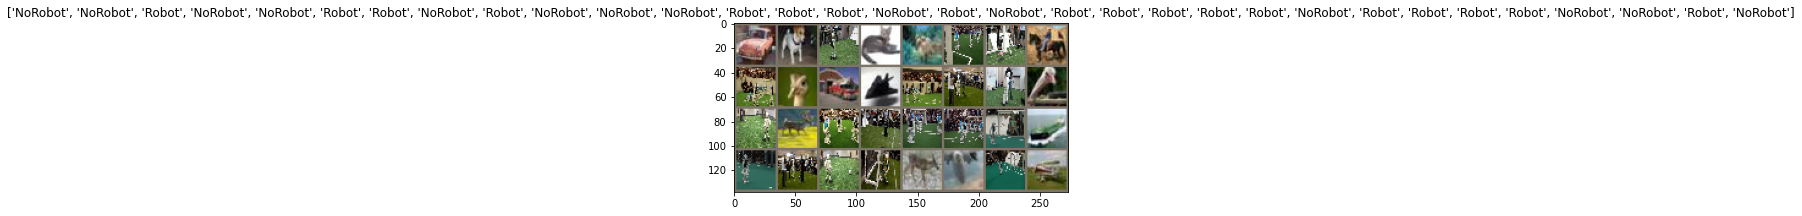

In [88]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_loader))
print(classes)

class_names = {0: "NoRobot", 1: "Robot"}

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

title=[class_names[x.item()] for x in classes]

imshow(out, title)

# Training

In [95]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Data processing
            for inputs, labels in dataloaders[phase]:
                
                # Move data to device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Clean the gradients
                optimizer.zero_grad()

                # Backprop steps
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()

                # Compute loss and correct predictions
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Pre-trained densenet

In [96]:
# Create model
model = torchvision.models.densenet121(pretrained=True, progress=True)
model.classifier = nn.Linear(model.classifier.in_features, 2)

# Pass model to device
model = model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer_ft = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Adaptive learning rate
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Fine-Tuning

In [97]:
model_ft = train_model(model, criterion, optimizer_ft, lr_scheduler, num_epochs=25)

Epoch 0/24
----------


KeyboardInterrupt: 